In [1]:
import numpy as np
import pandas as pd 
import re
from nltk import download
download('stopwords')
from nltk.corpus import stopwords
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chenanqi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
data = pd.read_csv("articles.csv")

In [3]:
stop_words = set(stopwords.words('english')) 

def text_cleaner(text,num):
    newString = text.lower()
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)  
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [4]:
cleaned_text = []
for t in data['text']:
    cleaned_text.append(text_cleaner(t,0))

In [5]:
data['text'][:3]

0    You can train your brain to think better. One of the best ways to do this is to expand the set of mental models you use to think. Let me explain what I mean by sharing a story about a world-class ...
1    First principles thinking, which is sometimes called reasoning from first principles, is one of the most effective strategies you can employ for breaking down complicated problems and generating o...
2    Murphy's Law states, “Anything that can go wrong, will go wrong.”\nThis pithy statement references the annoying tendency of life to cause trouble and make things difficult. Problems seem to arise ...
Name: text, dtype: object

In [6]:
cleaned_summary = []
for t in data['title']:
    cleaned_summary.append(text_cleaner(t,1))

In [7]:
data['title'][:3]

0        Mental Models: How to Train Your Brain to Think in New Ways?You can train your brain to think better. One of the best ways to do this is to expand the set of mental models you use to think.
1    First Principles: Elon Musk on the Power of Thinking for Yourself. First principles thinking does not remove the need for continuous improvement, but it does alter the direction of improvement.
2                                                                              Entropy: Why Life Always Seems to Get More Complicated. Murphy's Law states, Anything that can go wrong, will go wrong.
Name: title, dtype: object

In [8]:
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary

In [9]:
for i in range(3):
    print("Title:",data['cleaned_summary'][i])
    print("\n")

Title: mental models how to train your brain to think in new ways you can train your brain to think better one of the best ways to do this is to expand the set of mental models you use to think


Title: first principles elon musk on the power of thinking for yourself first principles thinking does not remove the need for continuous improvement but it does alter the direction of improvement


Title: entropy why life always seems to get more complicated murphy law states anything that can go wrong will go wrong




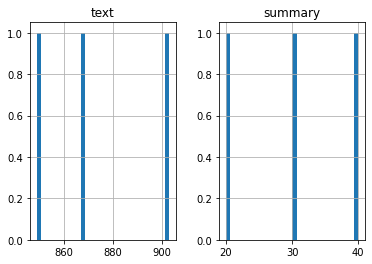

In [10]:
import matplotlib.pyplot as plt
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()

In [11]:
max_text_len=910
max_summary_len=40

In [12]:
count = 0
for i in data['cleaned_text']:
    if(len(i.split())<=max_text_len):
        count += 1
print(count/len(data['cleaned_text']))

1.0


In [13]:
cnt=0
for i in data['cleaned_summary']:
    if(len(i.split())<=max_summary_len):
        cnt=cnt+1
print(cnt/len(data['cleaned_summary']))

1.0


In [14]:
cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df=pd.DataFrame({'text':short_text,'summary':short_summary})

In [15]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [16]:
df['summary'][:3]

0    sostok mental models how to train your brain to think in new ways you can train your brain to think better one of the best ways to do this is to expand the set of mental models you use to think eo...
1    sostok first principles elon musk on the power of thinking for yourself first principles thinking does not remove the need for continuous improvement but it does alter the direction of improvement...
2                                                                             sostok entropy why life always seems to get more complicated murphy law states anything that can go wrong will go wrong eostok
Name: summary, dtype: object

In [17]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),
                                       test_size=0.1,random_state=0,shuffle=True)

In [18]:
x_tr=np.array(df['text'])
y_tr=np.array(df['summary'])

In [19]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [20]:
cnt=0
tot_cnt=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    
print(tot_cnt)

1183


In [21]:
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1
x_voc

1184

In [22]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [23]:
cnt=0
tot_cnt=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    
print(tot_cnt)

61


In [24]:
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1
y_voc

62

In [25]:
y_tokenizer.word_counts['eostok'],len(y_tr)

(3, 3)

In [26]:
from tensorflow.keras.models import Model
from keras import backend as K 
from attention_keras.src.layers.attention import AttentionLayer
K.clear_session()

latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 910)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 910, 100)     118400      input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 910, 300), ( 481200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
_______________________________________________________________________________________

In [27]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

In [28]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [29]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,
                  epochs=10,callbacks=[es],batch_size=128,validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 4.1266 - val_loss: 3.9516
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 4.0385 - val_loss: 2.9021
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 4.3819 - val_loss: 3.9053
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 3.9598 - val_loss: 2.7610
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 3.4049 - val_loss: 2.4113
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 3.2180 - val_loss: 2.2345
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 3.1122 - val_loss: 2.1332
Epoch 8/10
1/1 [==============================] - 2s 2s/step - loss: 3.0192 - val_loss: 2.0305
Epoch 9/10
1/1 [==============================] - 2s 2s/step - loss: 2.9434 - val_loss: 2.1215
Epoch 10/10
1/1 [==============================] - 2s 2s/step - loss: 2.9203 - val_loss: 1.8576


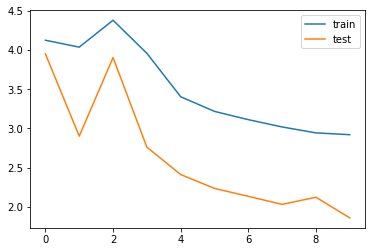

In [30]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [61]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [73]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])


In [92]:
def decode_sequence(input_seq):
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([[target_seq] + [e_out, e_h, e_c]])
        output_tokens = output_tokens[:1]
        h_1 = h[:1]
        c_1 = c[:1]
        prediction_output = output_tokens[0,-1,:]
        sampled_token_index = np.random.choice(len(prediction_output), p=prediction_output)+1
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token
    
        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok' or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [93]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [94]:
for i in range(len(x_tr)):
    print("Text:",seq2text(x_tr[i])[:300])
    print("Original title:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Text: train brain think better one best ways expand set mental models use think let explain mean sharing story world class thinker first discovered mental model useful right one could reading story richard feynman famous physicist feynman received undergraduate degree mit ph princeton time developed reput
Original title: models how to train your brain to think in new ways you can train your brain to think better one of the best ways to do this is to expand the set of mental models you use to think 
Predicted summary:  thinking will the always brain your the principles continuous more to


Text: first principles thinking sometimes called reasoning first principles one effective strategies employ breaking complicated problems generating original solutions also might single best approach learn think first principles approach used many great thinkers including inventor johannes gutenberg milit
Original title: first principles elon musk on the power of thinking for yourself first principles